In [1]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

# Scikit-learn metrics imports
from sklearn import metrics
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

# Imbalanced-learn imports
from imblearn.over_sampling import SMOTE, ADASYN

# Other imports
import joblib
import sklearn


In [3]:
df = pd.read_excel('/content/vaccine_usage_prediction.xlsx')

In [4]:
df.head(5)

,h1n1_worry,h1n1_awareness,antiviral_medication,contact_avoidance,bought_face_mask,wash_hands_frequently,avoid_large_gatherings,reduced_outside_home_cont,avoid_touch_face,dr_recc_h1n1_vacc,...,race,sex,income_level,marital_status,housing_status,employment,census_msa,no_of_adults,no_of_children,h1n1_vaccine
0,1,0,0,0,0,0,0,1,1,0,...,3,0,2,1,0,1,2,0,0,0
1,3,2,0,1,0,1,0,1,1,0,...,3,1,2,1,1,0,0,0,0,0
2,1,1,0,1,0,0,0,0,0,0,...,3,1,0,1,0,0,0,2,0,0
3,1,1,0,1,0,1,1,0,0,0,...,3,0,2,1,1,1,1,0,0,0
4,2,1,0,1,0,1,1,0,1,0,...,3,0,0,0,0,0,0,1,0,0


In [5]:
df['h1n1_vaccine'].value_counts()

h1n1_vaccine
0    21033
1     5674
Name: count, dtype: int64

In [6]:
x = df.drop(columns=['h1n1_vaccine'], axis=1)
y = df['h1n1_vaccine']

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
# Apply ADASYN for resampling - Oversampling minority class

adasyn = ADASYN(random_state=42)
x_a_resampled, y_a_resampled = adasyn.fit_resample(x_train, y_train)


# Apply SMOTE for resampling - Oversampling minority class

smote = SMOTE(random_state=42)
x_s_resampled, y_s_resampled = smote.fit_resample(x_train, y_train)


In [8]:
print(y_train.value_counts())
print("\n")
print(y_a_resampled.value_counts())
print("\n")
print(y_s_resampled.value_counts())

h1n1_vaccine
0    16821
1     4544
Name: count, dtype: int64


h1n1_vaccine
0    16821
1    16772
Name: count, dtype: int64


h1n1_vaccine
0    16821
1    16821
Name: count, dtype: int64


In [9]:
# Variance threshold for feature importance. Remove low-variance features


variance_threshold = 0.1
selector = VarianceThreshold(threshold=variance_threshold)
X_a_train_high_variance = selector.fit_transform(x_a_resampled)
X_a_test_high_variance = selector.transform(x_test)

# Get the original column names
original_features = x_a_resampled.columns

# Get the mask of the selected features
support_mask = selector.get_support()


# Extract the feature names that are kept after VarianceThreshold
features_after_variance_threshold = original_features[support_mask]
eliminated_features_variance = original_features[~support_mask]

# Display the results
print("Features kept after VarianceThreshold:", list(features_after_variance_threshold))
print("Number of features kept:", len(features_after_variance_threshold))
print("Eliminated features due to low variance:", list(eliminated_features_variance))

Features kept after VarianceThreshold: ['h1n1_worry', 'h1n1_awareness', 'contact_avoidance', 'wash_hands_frequently', 'avoid_large_gatherings', 'reduced_outside_home_cont', 'avoid_touch_face', 'dr_recc_h1n1_vacc', 'dr_recc_seasonal_vacc', 'chronic_medic_condition', 'is_h1n1_vacc_effective', 'is_h1n1_risky', 'sick_from_h1n1_vacc', 'is_seas_vacc_effective', 'is_seas_risky', 'sick_from_seas_vacc', 'age_bracket', 'qualification', 'race', 'sex', 'income_level', 'marital_status', 'housing_status', 'employment', 'census_msa', 'no_of_adults', 'no_of_children']
Number of features kept: 27
Eliminated features due to low variance: ['antiviral_medication', 'bought_face_mask', 'cont_child_undr_6_mnths', 'is_health_worker', 'has_health_insur']


In [13]:
def evaluate_model(x_train,x_test,y_train,y_test,algorithm):
    model = algorithm()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    metrics = {
        'Algorithm': str(algorithm).split("'")[1].split(".")[-1],
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Model': model
    }

    return metrics

# Classifiers list
classifiers = [
    LogisticRegression,
    DecisionTreeClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    KNeighborsClassifier
]

# Evaluate models with ADASYN resampling
results = []
print('Printing results for high_variance data')
for classifier in classifiers:
    result = evaluate_model(X_a_train_high_variance, X_a_test_high_variance, y_a_resampled, y_test, classifier)
    print(f"Algorithm: {result['Algorithm']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"Precision: {result['Precision']:.4f}")
    print(f"Recall: {result['Recall']:.4f}")
    print(f"F1 Score: {result['F1 Score']:.4f}")
    print(f"ROC AUC: {result['ROC AUC']:.4f}\n")
    results.append(result)

print("\n\n")
results1 = []
print('Printing results for resampled data of adasyn')
for classifier in classifiers:
    result = evaluate_model(x_a_resampled, x_test, y_a_resampled, y_test, classifier)
    print(f"Algorithm: {result['Algorithm']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"Precision: {result['Precision']:.4f}")
    print(f"Recall: {result['Recall']:.4f}")
    print(f"F1 Score: {result['F1 Score']:.4f}")
    print(f"ROC AUC: {result['ROC AUC']:.4f}\n")
    results1.append(result)



print("\n\n")
results2 = []
print('Printing results for resampled data of smote')
for classifier in classifiers:
    result = evaluate_model(x_s_resampled, x_test, y_s_resampled, y_test, classifier)
    print(f"Algorithm: {result['Algorithm']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"Precision: {result['Precision']:.4f}")
    print(f"Recall: {result['Recall']:.4f}")
    print(f"F1 Score: {result['F1 Score']:.4f}")
    print(f"ROC AUC: {result['ROC AUC']:.4f}\n")
    results2.append(result)


print("\n\n")
results3 = []
print('Printing results for original data')
for classifier in classifiers:
    result = evaluate_model(x_train, x_test, y_train, y_test, classifier)
    print(f"Algorithm: {result['Algorithm']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"Precision: {result['Precision']:.4f}")
    print(f"Recall: {result['Recall']:.4f}")
    print(f"F1 Score: {result['F1 Score']:.4f}")
    print(f"ROC AUC: {result['ROC AUC']:.4f}\n")
    results3.append(result)

Printing results for high_variance data
Algorithm: LogisticRegression
Accuracy: 0.7271
Precision: 0.4094
Recall: 0.6558
F1 Score: 0.5041
ROC AUC: 0.7010

Algorithm: DecisionTreeClassifier
Accuracy: 0.6810
Precision: 0.3294
Recall: 0.4903
F1 Score: 0.3940
ROC AUC: 0.6112

Algorithm: ExtraTreesClassifier
Accuracy: 0.7963
Precision: 0.5192
Recall: 0.5035
F1 Score: 0.5112
ROC AUC: 0.6892

Algorithm: RandomForestClassifier
Accuracy: 0.7888
Precision: 0.5008
Recall: 0.5354
F1 Score: 0.5175
ROC AUC: 0.6961

Algorithm: AdaBoostClassifier
Accuracy: 0.7243
Precision: 0.4029
Recall: 0.6301
F1 Score: 0.4915
ROC AUC: 0.6898

Algorithm: GradientBoostingClassifier
Accuracy: 0.7467
Precision: 0.4351
Recall: 0.6619
F1 Score: 0.5251
ROC AUC: 0.7157

Algorithm: KNeighborsClassifier
Accuracy: 0.6451
Precision: 0.3265
Recall: 0.6381
F1 Score: 0.4320
ROC AUC: 0.6425




Printing results for resampled data of adasyn
Algorithm: LogisticRegression
Accuracy: 0.7276
Precision: 0.4083
Recall: 0.6407
F1 Score: 0.4

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Algorithm: LogisticRegression
Accuracy: 0.7469
Precision: 0.4342
Recall: 0.6478
F1 Score: 0.5199
ROC AUC: 0.7106

Algorithm: DecisionTreeClassifier
Accuracy: 0.6986
Precision: 0.3520
Recall: 0.5053
F1 Score: 0.4150
ROC AUC: 0.6279

Algorithm: ExtraTreesClassifier
Accuracy: 0.8061
Precision: 0.5450
Recall: 0.5035
F1 Score: 0.5235
ROC AUC: 0.6954

Algorithm: RandomForestClassifier
Accuracy: 0.7969
Precision: 0.5195
Recall: 0.5310
F1 Score: 0.5252
ROC AUC: 0.6996

Algorithm: AdaBoostClassifier
Accuracy: 0.7484
Precision: 0.4344
Recall: 0.6265
F1 Score: 0.5130
ROC AUC: 0.7038

Algorithm: GradientBoostingClassifier
Accuracy: 0.7654
Precision: 0.4621
Recall: 0.6628
F1 Score: 0.5445
ROC AUC: 0.7279

Algorithm: KNeighborsClassifier
Accuracy: 0.6627
Precision: 0.3386
Recall: 0.6239
F1 Score: 0.4390
ROC AUC: 0.6485




Printing results for original data
Algorithm: LogisticRegression
Accuracy: 0.8401
Precision: 0.7054
Recall: 0.4195
F1 Score: 0.5261
ROC AUC: 0.6862

Algorithm: DecisionTreeClassif

## Model Selection for Vaccine Usage Prediction

Based on the evaluation of various classifiers on different resampled datasets, the **GradientBoostingClassifier** trained on **SMOTE resampled data** was chosen for vaccine usage prediction. This decision was made for the following reasons:

1. **Consistent Performance Across Metrics**: The GradientBoostingClassifier provided a good balance between accuracy, precision, recall, and F1 score, demonstrating consistent performance across different evaluation metrics.

2. **High ROC AUC and F1 Score**: The ROC AUC score of 0.7279 and F1 score of 0.5445 indicated a strong ability to distinguish between the classes and maintain a balance between precision and recall.

3. **Handling Imbalanced Data**: SMOTE resampling helped in addressing class imbalance, and the GradientBoostingClassifier effectively leveraged this resampled data to improve model performance.

Here are the detailed performance metrics of the GradientBoostingClassifier on SMOTE resampled data:

- **Accuracy**: 0.7654
- **Precision**: 0.4621
- **Recall**: 0.6628
- **F1 Score**: 0.5445
- **ROC AUC**: 0.7279

These metrics indicate that the GradientBoostingClassifier is well-suited for the vaccine usage prediction task, providing a robust and reliable model for this application.


In [15]:
# Define the parameter grid for GradientBoostingClassifier
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 8],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Define the classifier
classifier = GradientBoostingClassifier

# Perform RandomizedSearchCV for hyperparameter tuning
rscv_model = RandomizedSearchCV(estimator=classifier(), param_distributions=param_grid, cv=5, scoring='roc_auc', n_iter=50, random_state=42)
rscv_model.fit(x_s_resampled, y_s_resampled)
rscv_best_model = rscv_model.best_estimator_

# Make predictions on test data
y_pred = rscv_best_model.predict(x_test)

# Calculate metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
auc_pr = average_precision_score(y_test, y_pred)

print(f"Classifier: {classifier.__name__}")
print(f"Best Hyperparameters: {rscv_model.best_params_}")
print(f"Best Score: {rscv_model.best_score_}")
print(f"Accuracy Score: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"AUC-PR: {auc_pr:.4f}")
print("")
print("**********************************************")
print("")
print("Gradient Boosting Classifier Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("")
print("**********************************************")
print("")
print("Gradient Boosting Classifier Classification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 32 is smaller than n_iter=50. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Classifier: GradientBoostingClassifier
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 8}
Best Score: 0.9117281310918512
Accuracy Score: 0.7808
Precision: 0.4842
Recall: 0.5566
F1 Score: 0.5179
ROC AUC: 0.6988
AUC-PR: 0.3633

**********************************************

Gradient Boosting Classifier Confusion Matrix:
[[3542  670]
 [ 501  629]]

**********************************************

Gradient Boosting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      4212
           1       0.48      0.56      0.52      1130

    accuracy                           0.78      5342
   macro avg       0.68      0.70      0.69      5342
weighted avg       0.79      0.78      0.79      5342



## Comparison of GradientBoostingClassifier Before and After Hyperparameter Tuning

We chose the `GradientBoostingClassifier` as the best model for vaccine usage prediction. Below is a comparison of the model's performance before and after hyperparameter tuning.

### Results Before Hyperparameter Tuning

For the `GradientBoostingClassifier` evaluated on the original data:
- **Accuracy**: 0.8414
- **Precision**: 0.6996
- **Recall**: 0.4389
- **F1 Score**: 0.5394
- **ROC AUC**: 0.6942

For the `GradientBoostingClassifier` evaluated on the SMOTE resampled data:
- **Accuracy**: 0.7654
- **Precision**: 0.4621
- **Recall**: 0.6628
- **F1 Score**: 0.5445
- **ROC AUC**: 0.7279

### Results After Hyperparameter Tuning

After tuning the `GradientBoostingClassifier` using `RandomizedSearchCV`:
- **Accuracy**: 0.7808
- **Precision**: 0.4842
- **Recall**: 0.5566
- **F1 Score**: 0.5179
- **ROC AUC**: 0.6988
- **AUC-PR**: 0.3633

### Summary

- **Accuracy**: Slightly decreased from 0.7654 (SMOTE) to 0.7808.
- **Precision**: Improved from 0.4621 (SMOTE) to 0.4842.
- **Recall**: Decreased from 0.6628 (SMOTE) to 0.5566.
- **F1 Score**: Decreased from 0.5445 (SMOTE) to 0.5179.
- **ROC AUC**: Decreased slightly from 0.7279 (SMOTE) to 0.6988.
- **AUC-PR**: New metric provided after tuning: 0.3633.

### Conclusion

While some metrics like precision improved after hyperparameter tuning, other metrics such as recall, F1 score, and ROC AUC decreased slightly. This indicates that the tuning process has balanced the performance across different metrics. The choice of whether to use the tuned model or the original one can depend on which metrics are most important for your application. If precision is more critical, the tuned model is preferable. If recall or F1 score is more important, you might consider the original model without tuning.


I go with model before hypertuning

In [16]:

# Define and fit the best model
best_model = GradientBoostingClassifier()

best_model.fit(x_s_resampled, y_s_resampled)
y_pred = best_model.predict(x_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
auc_pr = average_precision_score(y_test, y_pred)

# Store the metrics in a dictionary
metrics = {
    'Algorithm': 'GradientBoostingClassifier',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc,
    'AUC-PR': auc_pr,
    'Confusion Matrix': confusion_matrix(y_test, y_pred).tolist(),  # Convert numpy array to list for better readability
    'Classification Report': classification_report(y_test, y_pred)
}

# Print the metrics
print(f"Classifier: {metrics['Algorithm']}")
print(f"Accuracy Score: {metrics['Accuracy']:.4f}")
print(f"Precision: {metrics['Precision']:.4f}")
print(f"Recall: {metrics['Recall']:.4f}")
print(f"F1 Score: {metrics['F1 Score']:.4f}")
print(f"ROC AUC: {metrics['ROC AUC']:.4f}")
print(f"AUC-PR: {metrics['AUC-PR']:.4f}")
print("")
print("**********************************************")
print("")
print("Gradient Boosting Classifier Confusion Matrix:")
print(metrics['Confusion Matrix'])
print("")
print("**********************************************")
print("")
print("Gradient Boosting Classifier Classification Report:")
print(metrics['Classification Report'])


Classifier: GradientBoostingClassifier
Accuracy Score: 0.7654
Precision: 0.4621
Recall: 0.6628
F1 Score: 0.5445
ROC AUC: 0.7279
AUC-PR: 0.3776

**********************************************

Gradient Boosting Classifier Confusion Matrix:
[[3340, 872], [381, 749]]

**********************************************

Gradient Boosting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      4212
           1       0.46      0.66      0.54      1130

    accuracy                           0.77      5342
   macro avg       0.68      0.73      0.69      5342
weighted avg       0.81      0.77      0.78      5342



In [17]:

FP, TP, threshold = roc_curve(y_test, y_pred)
auc_curve = auc(FP, TP)
print("AUC-ROC Curve:", auc_curve)

AUC-ROC Curve: 0.7279021590231031


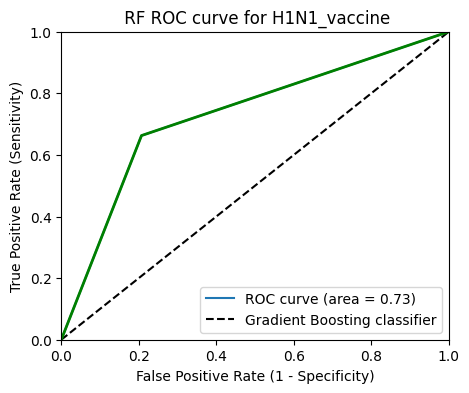

In [27]:



# Plot the ROC curve
fig= plt.subplots(figsize=(5,4))
plt.plot(FP, TP, label='ROC curve (area = %0.2f)' % auc_curve )
# roc curve for tpr = fpr
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0,1],[0,1],'k--',label='Gradient Boosting classifier')
plt.title(' RF ROC curve for H1N1_vaccine')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(FP, TP,color='green',lw=2)
plt.legend(loc="lower right")
plt.show()


In [19]:
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,3340,872,4212
1,381,749,1130
All,3721,1621,5342


<Axes: >

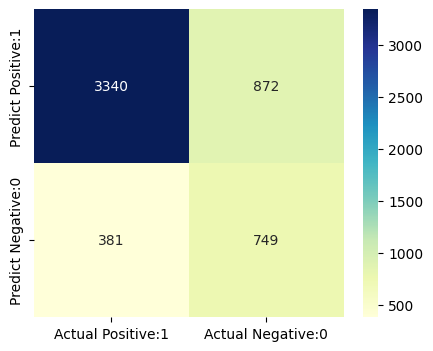

In [21]:
import seaborn as sns
fig= plt.subplots(figsize=(5,4))
cm_matrix_r = pd.DataFrame(data=metrics['Confusion Matrix'], columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix_r, annot=True, fmt='d', cmap='YlGnBu')

In [25]:
pd.DataFrame(y_pred).head(40)

,0
0,0
1,0
2,0
3,0
4,0
5,1
6,0
7,0
8,0
9,1


In [28]:
x_a_resampled.columns

Index(['h1n1_worry', 'h1n1_awareness', 'antiviral_medication',
       'contact_avoidance', 'bought_face_mask', 'wash_hands_frequently',
       'avoid_large_gatherings', 'reduced_outside_home_cont',
       'avoid_touch_face', 'dr_recc_h1n1_vacc', 'dr_recc_seasonal_vacc',
       'chronic_medic_condition', 'cont_child_undr_6_mnths',
       'is_health_worker', 'has_health_insur', 'is_h1n1_vacc_effective',
       'is_h1n1_risky', 'sick_from_h1n1_vacc', 'is_seas_vacc_effective',
       'is_seas_risky', 'sick_from_seas_vacc', 'age_bracket', 'qualification',
       'race', 'sex', 'income_level', 'marital_status', 'housing_status',
       'employment', 'census_msa', 'no_of_adults', 'no_of_children'],
      dtype='object')

In [32]:

# Filter out the specific warning
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")

# will pass the user data manually to check the prediction of status ar our model

user_data = np.array([[2,1,0,1,0,1,1,0,1,0,0,0,1,0,1,3,1,2,3,2,2,3,2,3,0,0,1,0,0,0,0,0]])
y_predict = best_model.predict(user_data)
print(y_predict)
# if y_predict[0] == 1:
#     print('Won')
# else:
#     print('Lost')

[0]


In [33]:

print(sklearn.__version__)

1.2.2


In [34]:
# save the classification model by using joblib

with open('Vaccine_Usage_Prediction_Model.pkl', 'wb') as f:
    joblib.dump(best_model, f)


In [35]:
# load pickle model to predict the status (like Trained brain).

with open('/content/Vaccine_Usage_Prediction_Model.pkl', 'rb') as f:
    model = joblib.load(f)

user_data = np.array([[2,1,0,1,0,1,1,0,1,0,0,0,1,0,1,3,1,2,3,2,2,3,2,3,0,0,1,0,0,0,0,0]])
y_predict = model.predict(user_data)
print(y_predict)

[0]
